In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from PIL import Image

### Data Preprocessing

In [2]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx, 0]
        pixels = self.dataframe.iloc[idx, 1]

        # Image processing
        image = np.array(pixels.split(), dtype='float32').reshape(48, 48)
        image = Image.fromarray(image).convert('L')  # Convert grayscale to RGB

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Combine FER2013 and Facial Emotion data
def load_and_combine_data(fer2013_path, additional_data_path, dataset_dir):
    # load fer2013 dataset
    fer_data = pd.read_csv(fer2013_path, compression='zip')
    fer_data = fer_data[~fer_data['emotion'].isin([1, 2])]  # Remove "disgust" and "fear"
    fer_data.reset_index(drop=True, inplace=True)

    # Adjust label encoding
    def adjust_label(x):
        if x > 2:
            return x - 2  # Shift labels 3-6 forward by 2
        return x  # Keep labels 0 and 1 unchanged
    
    fer_data['emotion'] = fer_data['emotion'].apply(adjust_label)

    # Load additional data
    additional_data = pd.read_csv(additional_data_path)
    images, labels = [], []

    for _, row in additional_data.iterrows():
        img_path = os.path.join(dataset_dir, row['filename'])
        img = Image.open(img_path).convert('L').resize((48, 48))
        images.append(' '.join(map(str, np.array(img).flatten())))
        labels.append(row['label'])

    additional_data_df = pd.DataFrame({'emotion': labels, 'pixels': images})

    # Combine data
    combined_data = pd.concat([fer_data, additional_data_df], ignore_index=True)
    return combined_data

In [4]:
# Load data
zip_path = '../data_storage/fer2013.zip'
additional_csv = '../data_storage/facial_adjusted.csv'
dataset_dir = '../data_storage/dataset'

combined_data = load_and_combine_data(zip_path, additional_csv, dataset_dir)


In [5]:
combined_data_clean = combined_data.drop(columns=['Usage'])
combined_data_clean.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
4,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...


In [6]:
combined_data_clean['emotion'].value_counts()

emotion
1    12729
4    10225
2    10011
0     6266
3     5236
Name: count, dtype: int64

In [7]:
label_to_emotion = {
    0: "Angry",
    1: "Happy",
    2: "Sad",
    3: "Surprise",
    4: "Neutral"
}
combined_data_dist = combined_data_clean['emotion'].map(label_to_emotion).value_counts()
combined_data_dist

emotion
Happy       12729
Neutral     10225
Sad         10011
Angry        6266
Surprise     5236
Name: count, dtype: int64

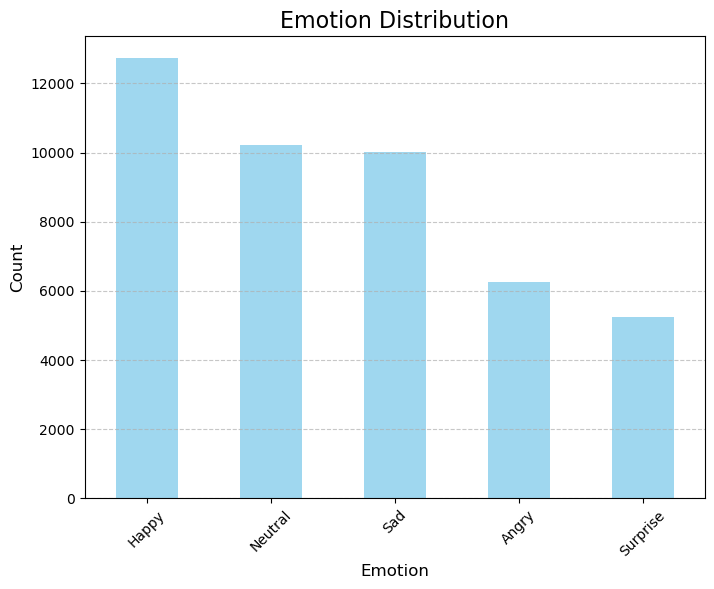

In [8]:
import matplotlib.pyplot as plt

combined_data_clean['emotion_name'] = combined_data_clean['emotion'].map(label_to_emotion)
emotion_counts = combined_data_clean['emotion_name'].value_counts()
# plot a bar chart 
plt.figure(figsize=(8, 6))
emotion_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Emotion Distribution', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [9]:
def split_data(combined_data_clean):
    from sklearn.model_selection import train_test_split

    # Split training/validation set and test set
    train_val_data, test_data = train_test_split(
        combined_data_clean, 
        test_size=0.2, 
        random_state=42, 
        stratify=combined_data['emotion']
    )

    # Split training set and validation set
    train_data, val_data = train_test_split(
        train_val_data, 
        test_size=0.2, 
        random_state=42, 
        stratify=train_val_data['emotion']
    )

    return train_data, val_data, test_data

In [10]:
train_data, val_data, test_data = split_data(combined_data_clean)

# Define data augmentation
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = EmotionDataset(train_data, transform=transform)
val_dataset = EmotionDataset(val_data, transform=transform)
test_dataset = EmotionDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### Model Building

In [11]:
# load ResNet,  pre-train model
model = models.resnet50(pretrained=True)

# Modify the output layer to 5 classes
num_classes = 5
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

d:\Program Files\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training and Validating

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

In [13]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)
torch.save(model.state_dict(), 'resnet18_emotion_model_30_.pth')
print("Model saved successfully!")

Epoch [1/50], Loss: 1.1578, Val Loss: 1.0423, Val Accuracy: 57.79%
Epoch [2/50], Loss: 0.9213, Val Loss: 0.9004, Val Accuracy: 64.26%
Epoch [3/50], Loss: 0.8141, Val Loss: 0.8158, Val Accuracy: 67.56%
Epoch [4/50], Loss: 0.7702, Val Loss: 0.7866, Val Accuracy: 69.56%
Epoch [5/50], Loss: 0.7443, Val Loss: 0.8088, Val Accuracy: 68.60%
Epoch [6/50], Loss: 0.7140, Val Loss: 0.7768, Val Accuracy: 69.44%
Epoch [7/50], Loss: 0.6859, Val Loss: 0.7893, Val Accuracy: 70.86%
Epoch [8/50], Loss: 0.6420, Val Loss: 0.7648, Val Accuracy: 70.34%
Epoch [9/50], Loss: 0.6432, Val Loss: 0.7938, Val Accuracy: 70.11%
Epoch [10/50], Loss: 0.5950, Val Loss: 0.7478, Val Accuracy: 72.07%
Epoch [11/50], Loss: 0.5982, Val Loss: 1.0068, Val Accuracy: 67.88%
Epoch [12/50], Loss: 0.6202, Val Loss: 0.7749, Val Accuracy: 70.36%
Epoch [13/50], Loss: 0.5166, Val Loss: 0.7997, Val Accuracy: 70.77%
Epoch [14/50], Loss: 0.4609, Val Loss: 0.8030, Val Accuracy: 71.52%
Epoch [15/50], Loss: 0.4185, Val Loss: 0.8159, Val Accura

### Model Testing

In [15]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
test_model(model, test_loader)

Test Accuracy: 69.69%
